## Reimplementation Structurally constrained recurrent nets (SCRN) by Keras

This model proposed by Tomas Mikolov, Armand Joulin, Sumit Chopra, Michael Mathieu, and Marc'Aurelio Ranzato. [Learning Longer Memory in Recurrent Neural Networks](http://arxiv.org/abs/1412.7753).

In [1]:
import numpy as np
np.random.seed(13)

from keras import backend as K
from keras import initializations, activations
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, Lambda, Input, Recurrent, merge, TimeDistributed, Activation
from keras.engine import InputSpec
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback
from keras.utils.visualize_util import model_to_dot, plot

from IPython.display import SVG
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

Using Theano backend.


In [2]:
def sample(p):
    p /= sum(p)
    return np.argmax(np.random.multinomial(1, p, 1))

In [3]:
class ContextRNN(Recurrent):
    def __init__(self,
                 init='zero',
                 alpha=0.95,
                 **kwargs):

        self.init = initializations.get(init)
        self.alpha = alpha

        super(ContextRNN, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        if self.stateful:
            self.reset_states()
        else:
            self.states = [None]
        input_dim = input_shape[2]
        self.input_dim = input_dim
        self.output_dim = input_dim

    def reset_states(self):
        assert self.stateful, 'Layer must be stateful.'
        input_shape = self.input_spec[0].shape
        if not input_shape[0]:
            raise Exception('If a RNN is stateful, a complete ' +
                            'input_shape must be provided (including batch size).')
        if hasattr(self, 'states'):
            K.set_value(self.states[0],
                        np.zeros((input_shape[0], self.output_dim)))
        else:
            self.states = [K.zeros((input_shape[0], self.output_dim))]

    def step(self, x, states):
        prev_output = states[0]
        output = (1.-self.alpha)*x + (self.alpha)*prev_output
        return output, [output]

    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'alpha': self.alpha
                  }
        base_config = super(ContextRNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
path = get_file('alice.txt', origin="http://www.gutenberg.org/cache/epub/11/pg11.txt")
doc = open(path).readlines()
doc = ["<BOS> " + sentence + "EOS" for sentence in doc if sentence.count(" ") > 2]
tokenizer = Tokenizer()
tokenizer.fit_on_texts(doc)
doc = tokenizer.texts_to_sequences(doc)
V = len(tokenizer.word_index)+1

In [5]:
data = []
targets = []
for sentence in doc:
    for i in range(1, len(sentence)):
        start = 0
        data.append(sentence[start:i])
        targets.append(sentence[i])

Y = np_utils.to_categorical(targets, V)
maxlen = max(map(len, data))
X = sequence.pad_sequences(data, maxlen=maxlen)
print(X.shape, Y.shape)

(33115, 19) (33115, 3318)


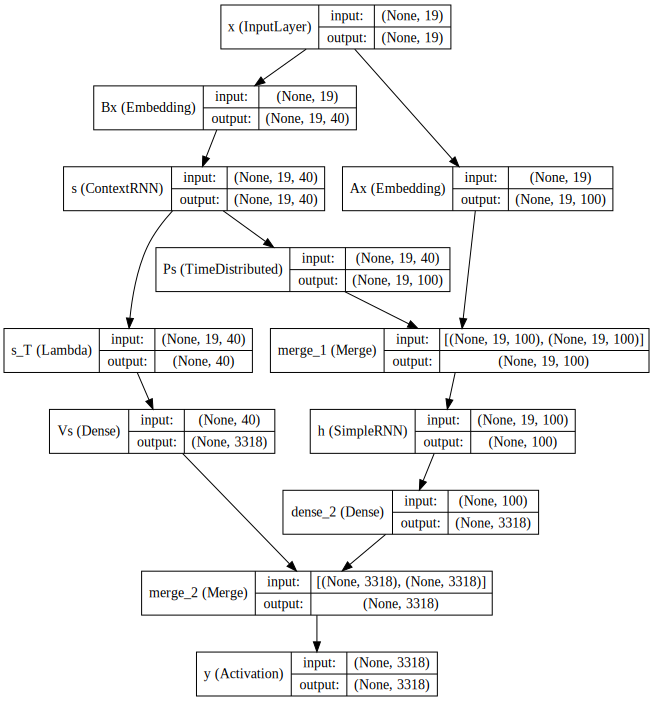

In [6]:
def get_RNN_last(x):
    return x[:,-1,:]

def get_RNN_last_shape(input_shape):
    assert len(input_shape) == 3
    return (None, input_shape[-1])

nb_hidden = 100
nb_context = 40
m = 100
w = Input(shape=(maxlen,), dtype='int32', name='x')

#slow
b = Embedding(output_dim=nb_context, input_dim=V, input_length=maxlen, name='Bx')(w)
s = ContextRNN(return_sequences=True, name="s")(b)
ps = TimeDistributed(Dense(m), name="Ps")(s)

s = Lambda(lambda x: get_RNN_last(x), output_shape=get_RNN_last_shape, name="s_T")(s)
v = Dense(V, name="Vs")(s)

# fast
x = Embedding(output_dim=m, input_dim=V, input_length=maxlen, name='Ax')(w)
x = merge([x, ps], mode='sum')

x = SimpleRNN(nb_hidden, activation="sigmoid", return_sequences=False, name="h")(x)
x = Dense(V)(x)
x = merge([x,v], mode='sum')
y = Activation("softmax", name='y')(x)

model = Model(input=w, output=y)

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [8]:
class Show(Callback):
    def on_epoch_end(self, epoch, logs={}):
        in_words = "<bos>"
        for _ in range(maxlen):
            in_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences([in_words]), maxlen=maxlen)
            wordid = sample(model.predict(in_sequence)[0])
            for k, v in tokenizer.word_index.items():
                if v == wordid:
                    in_words += " " + k
                    break
            if k == "eos":
                break
        print(in_words.replace(" eos", "").replace("<bos> ", ""))

show = Show()

In [9]:
model.fit(X, Y, batch_size=128, nb_epoch=32, validation_split=0.2, callbacks=[show], verbose=0)

arch 'how the a and sides lodging the alice ledge she ' her way look the anything
get 'that's were went very bird
with ' feelings a any cat counting ' party more bad more at
tidy that page to morning soup sending all in clinging to something but little one to
used 'or ' she with quarrel which i hat gryphon compressed several take a
at length work into does very would and
hare say nasty ' looking ought i these ' while arm gryphon
said curious wondering i'm feel the is she look wonder
of did but place under footman it for you
becoming before as a be so not manage and wandered bawled to why '
my got soup next timidly evidently wonder first and for 'what all who bottle cook
very checked 'it no 'now as pair the 'somebody child ' and ' fancy
mallets quite chuckled child into much then a in sudden read their said some
for and haven't was curving ' the i 'you see
went under herself answered quite she with she wind just
my kitchen twinkle gloves said at too about ' might lonely you join know
qu

## random sampling

In [10]:
for i in range(30):
    in_words = "<bos>"
    for _ in range(maxlen):
        in_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences([in_words]), maxlen=maxlen)
        wordid = sample(model.predict(in_sequence)[0])
        for k, v in tokenizer.word_index.items():
            if v == wordid:
                in_words += " " + k
                break
        if k == "eos":
            break

    print(i, in_words.replace(" eos", "").replace("<bos> ", ""))

0 might knew she branches in the hatter of reach to by listening question conduct
1 heard appealed it ' it to take you 'oh it's 'with to
2 to kept can queen it canterbury certainly she as a throne looking hard '
3 be four a way it her know '
4 lived but thought the argument it's a first skurried and ancient tell do mine to how
5 downloading to the it was deny there up come because bats a queen's dear in
6 smiling i drive ' at alice ix that made herself no if on an pleases were duchess of last
7 you sea you lost lessen quite 'but at the duchess as on as a shook
8 muchness a dodo spite 'it deep ' he boy for
9 any all and which globe that i the 'advance baked it can't
10 went had once the i'm lizard's i wrote 'there poor round 'thank such it looked heard
11 with some house like in the little better' will 'he's 'don't went for she found
12 a like to our dears ever alone i'd a hurry him
13 first nothing at the 'of return or memory to
14 oh made that agony or across round i'm could accounts 

In [11]:
for i in range(30):
    in_words = "<bos> alice"
    for _ in range(maxlen):
        in_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences([in_words]), maxlen=maxlen)
        wordid = sample(model.predict(in_sequence)[0])
        for k, v in tokenizer.word_index.items():
            if v == wordid:
                in_words += " " + k
                break
        if k == "eos":
            break


    print(i, in_words.replace("eos", "").replace("<bos> ", ""))

0 alice 'ah mean on procession she was were hard 
1 alice sort to the stalk and soup you got to off thunder the were mustard 
2 alice with she her tried said if very gryphon and you 
3 alice ' the frightened lobsters them its night it first 'how ' again the came and 
4 alice as got was up to felt ' said the top 
5 alice again to that said that and there for did her 
6 alice frightened in the two was copy but to alice 501 it not 
7 alice exclaimed uncomfortable think looked the found ' 
8 alice their cause of one and neck been went 
9 alice watch i long i was uncommonly that they'd make the three hare to alice 
10 alice paw was lastly ' i 'i put at sort wig very what it 
11 alice chain stand identification begin out on very little good reason the had of be 
12 alice down again say to it copyright to which near it the hatter of 
13 alice ' up that a ought 
14 alice to return looked ' 
15 alice am wood it you ii 
16 alice trumpet believe to it why she ' ' 
17 alice quite ran no moment in 

## maximum

In [12]:
in_words = "<bos> "
for _ in range(maxlen):
    in_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences([in_words]), maxlen=maxlen)
    wordid = np.argmax(model.predict(in_sequence)[0])

    for k, v in tokenizer.word_index.items():
        if v == wordid:
            in_words += " " + k
            break
    if k == "eos":
        break

print(in_words.replace("eos", "").replace("<bos> ", ""))

 the little little little little little little little 


In [13]:
in_words = "<bos> alice"
for _ in range(maxlen):
    in_sequence = sequence.pad_sequences(tokenizer.texts_to_sequences([in_words]), maxlen=maxlen)
    wordid = np.argmax(model.predict(in_sequence)[0])
    for k, v in tokenizer.word_index.items():
        if v == wordid:
            in_words += " " + k
            break
    if k == "eos":
        break


print(in_words.replace("eos", "").replace("<bos> ", ""))

alice ' said the little little little little 
